# Projets: Suggestions de Tags 

Pour ce projet, l'objectif est de développer un système de suggestions de tags pour le site **StackOverflow**. Le problème que l'on cherchera à résoudre est ici un problème de classification multi-label.

Les données sont obtenues via la plateforme [StackExchange Data Explorer](https://data.stackexchange.com/stackoverflow/query/new), et consistent en un grand nombre de *questions* (texte non-structuré) avec les *tags* qui leurs sont associés. Pour récupérer plus de résultats pertinents, les contraintes ci-dessous ont été appliquées sur certaines données
  1. les questions les plus vues, 
  2. mises en favori par les internautes et ayant reçu une réponse 
  3. et ayant au moins 5 tags.
  
Dans ce notebook, nous allons procéder au nettoyage du dataset obtenu. Le jeu de données comptant plus de 11 000 tags uniqes, on effectue, dans un premier temps, une sélection parmi les tags ayant été mentionnés le plus grand nombre de fois. Enfin, les méthodes classiques de nettoyage de textes en NLP seront appliquées. 


# <font color="#00afe6">Sommaire</font>
1. [Sélection des meilleurs tags.](#section_1)                       
2. [Nettoyage du jeu de données.](#section_2)    
    2.1 [Suppression des codes et balises HTML.](#section_2_1)            
    2.2 [Tokenization & Lemmatization.](#section_2_2)            
    2.3 [Uniformisation de la longueur des textes.](#section_2_3)            

In [1]:
# Importation des librairies python
import sys
import re

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

from tqdm import tqdm
tqdm.pandas()

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_orig = pd.read_csv('QueryResults_1a5.csv')
df = df_orig.copy()

In [3]:
df.sample(2)

,Title,Body,Tags,Id
22325,jQuery validate: How to add a rule for regular expression validation?,"<p>I am using the <strong><a href=""http://en.wikipedia.org/wiki/JQuery"" rel=""noreferrer"">jQuery</a> validation plugin</strong>. Great stuff! I want to migrate my existing ASP.NET solution to use jQuery instead of the ASP.NET validators. I am missing a replacement for the <strong>regular expression</strong> validator. I want to be able to do something like this:</p>\n\n<pre><code>$(""Textbox"").rules(""add"", { regularExpression: ""^[a-zA-Z'.\s]{1,40}$"" })\n</code></pre>\n\n<p>How do I <strong>add a custom rule</strong> to achieve this?</p>\n",<jquery><regex><jquery-validate>,280759
24956,Why use Oracle Application Express for web app?,"<p>I believe we're moving to Oracle Apex for future development. I've read about Oracle Apex on wikipedia and it's pro and con. It seem to me the con outweigh the pro but maybe I'm wrong. I get the sense that Oracle Apex is for DBA with little or no programing knowledge to setup a web app quickly sort like MS Access for none programmer.</p>\n\n<p>If you have Oracle Apex working experience, can you share your thought? From Wikipedia's entry, it doesn't seem like you need to know any programming language at all but just the PL/SQL?</p>\n\n<p>edit: Is Oracle Apex scalable? Can it handle traffic like Facebook's size?</p>\n\n<p>edit: after working nearly two years on Oracle Apex 3.2. I can safely said that I hate it and I don't see why anyone would want to create web app/page on browser, pl/sql and no way to do version control. </p>\n\n<p>Thank.</p>\n\n<p>Jack</p>\n",<oracle-apex>,652587


In [4]:
# Fonction pour afficher la taille, le nombre de valeurs uniques et le nombre de valeurs nulles
def show_isNull_NUnique_shape(df):
    print("Le dataframe contient {} colonnes et {} lignes."\
          .format(df.shape[1],df.shape[0]))
    print()
    print('NUnique')
    print('---'*2)
    for col in df.columns:
        print(f'{col :=<50} {df[col].nunique()}')
    print()
    print('IsNull')
    print('---'*2)
    for col in df.columns:
        print(f'{col :=<50} {df[col].isnull().sum()}') 
        
show_isNull_NUnique_shape(df)

Le dataframe contient 4 colonnes et 50000 lignes.

NUnique
------
Title============================================= 49998
Body============================================== 50000
Tags============================================== 39007
Id================================================ 50000

IsNull
------
Title============================================= 0
Body============================================== 0
Tags============================================== 0
Id================================================ 0


La colonne `Id` est constituée à 100% de valeurs uniques. Nous allons l'utiliser pour indexer le dataframe.

In [5]:
df = df.set_index('Id')

# <font color="blue" id=section_1> 1. Sélection des meilleurs tags. </font>

In [6]:
# Remplacement des balises entre les tags
df['Tags'] = df['Tags'].str.translate(str.maketrans({'<': '', '>': ','}))

# Suppression du ","
df['Tags'] = df['Tags'].str[:-1]

# Création d'une nouvelle colonne pour lister les tags 
df['Tags_list'] = df['Tags'].apply(lambda x : x.split(','))

# Comptage du nombre de tags pour chaque question
df['Tags_count'] = df['Tags_list'].apply(lambda x: len(x))

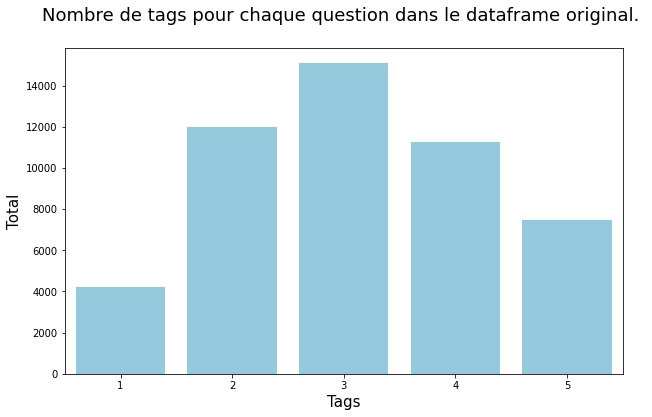

In [19]:
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(x=df.Tags_count, color="skyblue")
ax.set_xlabel("Tags", fontsize=15)
ax.set_ylabel("Total", fontsize=15)
plt.title("Nombre de tags pour chaque question dans le dataframe original. \n", fontsize=18)
plt.show()
fig.savefig('orig_nb_tags.png')

In [20]:
# Fonction pour compter le nombre de tags unique dans le dataframe
def split_and_count_tags(df, column, separator):
    list_words = []
    
    for word in df[column]:
        list_words.extend(word)
        
    df_list_words = pd.DataFrame(list_words, columns=["Tag"])
    df_list_words = df_list_words.groupby("Tag")\
        .agg(tag_count=pd.NamedAgg(column="Tag", aggfunc="count"))
    
    df_list_words.sort_values("tag_count", ascending=False, inplace=True)
    
    return df_list_words

In [21]:
tags_list = split_and_count_tags(df=df, column='Tags_list', separator=',')
print("Le jeu de données compte {} tags uniques.".format(tags_list.shape[0]))

Le jeu de données compte 11708 tags uniques.


Regardons le top des tags les plus utilisés dans le dataframe.

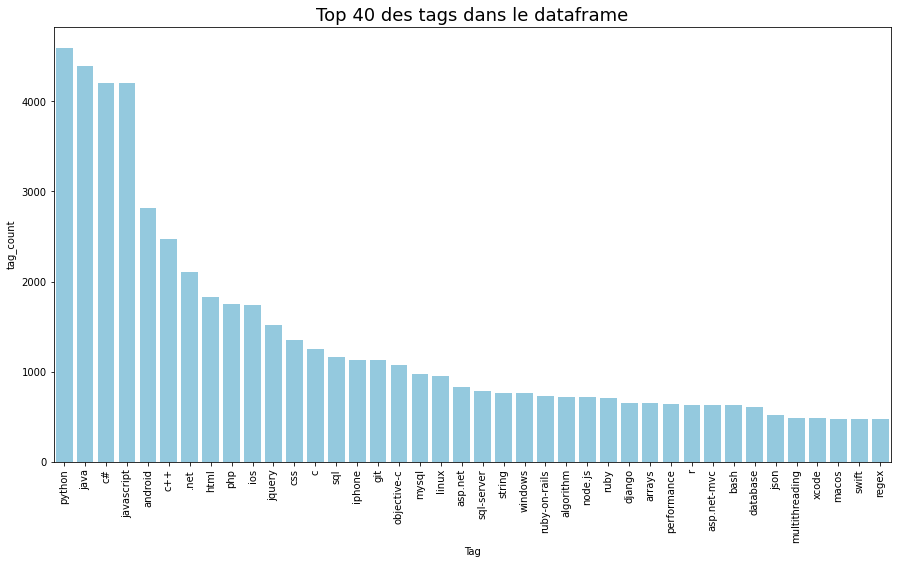

In [22]:
# Plot top best tags
top = 40
fig = plt.figure(figsize=(15, 8))
sns.barplot(data=tags_list.iloc[0:top, :],
            x=tags_list.iloc[0:top, :].index,
            y="tag_count", color="skyblue")
plt.xticks(rotation=90)
plt.title(f"Top {top} des tags dans le dataframe", fontsize=18)
plt.show()

In [23]:
# Nombre de tags unique
unique_tag = tags_list[tags_list['tag_count']==1]

print(f"Il y a {unique_tag.shape[0]} de tags ayant été utilisé une seule fois.")

Il y a 4986 de tags ayant été utilisé une seule fois.


Parmi les 11708 tags présents, on ne va retenir que ceux qui ont été utilisé au moins 500 fois.

In [24]:
def filter_tag_fct(tags, list_tags):
    matches = [match for match in tags.split(',') if match not in list_tags]
    return matches

# Nombre d'occurence minimum
min_unique_tag = 500
unique_tag_lists = list(tags_list[tags_list['tag_count']<min_unique_tag].index.values)

# Création d'une nouvelle colonne pour les tags les plus utilisés
df['Best_Tags'] = df['Tags'].progress_apply(lambda x : filter_tag_fct(x,unique_tag_lists))

# Count 
best_tags_list = split_and_count_tags(df=df, column='Best_Tags', separator=',')
print(f"Le jeu de données compte à présent {best_tags_list.shape[0]} tags.")

100%|██████████| 50000/50000 [00:49<00:00, 1014.41it/s]


Le jeu de données compte à présent 35 tags.


In [25]:
df['Best_Tags_count'] = df['Best_Tags'].apply(lambda x: len(x))

Nous devons maintenant supprimer du dataframe les lignes qui n'ont plus de tags. Regardons leur nombre.

In [26]:
print(f"Il y a {df[df['Best_Tags'].str.len() == 0].shape[0]} lignes sans tags.")

Il y a 11294 lignes sans tags.


In [27]:
# On supprime donc ces lignes
df = df[~df.index.isin(df[df['Best_Tags'].str.len() == 0].index)]

print(f"Le dataframe contient à présent {df.shape[0]} lignes.")

Le dataframe contient à présent 38706 lignes.


In [28]:
# # Plot the result
# plt.figure(figsize=(15,6))
# ax = sns.countplot(x=df.Best_Tags_count)
# ax.set_xlabel("Best Tags")
# plt.title("Number of tags used per question",
#           fontsize=18)
# plt.show()

In [29]:
df.Best_Tags_count.value_counts()

1    27547
2     9569
3     1442
4      138
5       10
Name: Best_Tags_count, dtype: int64

Pour finir, nous allons garder les lignes ayant au plus 3 tags. Le déséquilibre de classes sera alors réduit.

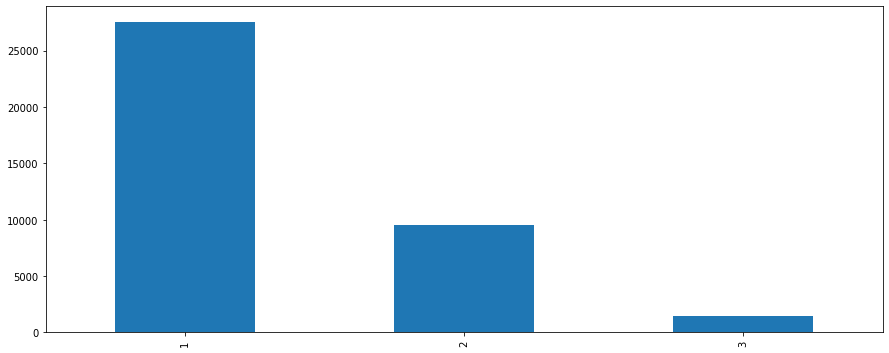

In [30]:
df = df[df['Best_Tags_count']<=3]
df['Best_Tags_count'].value_counts().plot(kind='bar',figsize=(15,6))
plt.show()

In [31]:
df.columns

Index(['Title', 'Body', 'Tags', 'Tags_list', 'Tags_count', 'Best_Tags',
       'Best_Tags_count'],
      dtype='object')

On peut maintenant supprimer les colonnes redondantes qui ont été créées pour cette première partie de nettoyage des données.

In [32]:
df = df.drop(['Tags',
              'Tags_list',
              'Tags_count',
#               'Best_Tags_count'
             ], axis=1)

# <font color="blue" id=section_2> 2. Nettoyage du jeu de données. </font>

Pour observer l'effet du néttoyage de texte à chaque étape, on sélectionne une liste d'indices qui nous serviront de marqueurs.

In [33]:
idx_list = [198496,  3190870,  4083351, 21396524, 36901,  3366506, 428884,  45469214] # 4730787,
df.loc[idx_list] 

Title  \
Id                                                                                                  
198496                      Difference between the System.Array.CopyTo() and System.Array.Clone()   
3190870                                         'const string' vs. 'static readonly string' in C#   
4083351                                                                 What does jQuery.fn mean?   
21396524                 What is the difference between “assert”, “expect”, and “should” in Chai?   
36901                What does ** (double star/asterisk) and * (star/asterisk) do for parameters?   
3366506                                                                  Extract p-value from aov   
428884                                                                How to play MP3 files in C?   
45469214  Why does the most negative int value cause an error about ambiguous function overloads?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# <font color="blue" id=section_2_1> 2.1 Suppression des codes et balises HTML. </font>

In [22]:
from bs4 import BeautifulSoup

def remove_code(x):
    """Function based on the Beautifulsoup library intended to replace 
    the content of all the <code> </code> tags of a text specified as a parameter.

    Parameters
    ----------------------------------------
    x : string
        Sequence of characters to modify.
    ----------------------------------------
    """
    soup = BeautifulSoup(x,"lxml")
    code_to_remove = soup.findAll("code")
    for code in code_to_remove:
        code.replace_with(" ")
    return str(soup)

df['Body'] = df['Body'].progress_apply(remove_code)

100%|██████████| 38558/38558 [00:23<00:00, 1671.91it/s]


In [23]:
df.loc[idx_list] 

,Title,Body,Best_Tags,Best_Tags_count
Id,,,,
198496,Difference between the System.Array.CopyTo() and System.Array.Clone(),<html><body><p>What’s the difference between the and ?</p>\n</body></html>,"[c#, .net, arrays]",3
3190870,'const string' vs. 'static readonly string' in C#,"<html><body><p>In C#, what's the difference between</p>\n<pre> </pre>\n<p>and</p>\n<pre> </pre>\n<p>?</p>\n</body></html>",[c#],1
4083351,What does jQuery.fn mean?,<html><body><p>What does the here mean?</p>\n<pre> </pre>\n</body></html>,"[javascript, jquery]",2
21396524,"What is the difference between “assert”, “expect”, and “should” in Chai?","<html><body><p>What is the difference between , , and ? When to use what?</p>\n<pre class=""lang-js prettyprint-override""> </pre>\n</body></html>",[javascript],1
36901,What does ** (double star/asterisk) and * (star/asterisk) do for parameters?,<html><body><p>What do and mean?</p>\n<pre> </pre>\n</body></html>,[python],1
3366506,Extract p-value from aov,"<html><body><p>I am looking to extract the p-value generated from an anova in R. </p>\n<p>Here is what I am running:</p>\n<pre> </pre>\n<p>Yields:</p>\n<pre> </pre>\n<p>When I look a the structure, this is what I see. I usually can work through lists to get what I need, but I am having a hard time with this one. A Google searched also seemed to reveal much simpler structures than I am getting.</p>\n<p>NOTE: ASQ is my data frame.</p>\n<pre> </pre>\n</body></html>",[r],1
428884,How to play MP3 files in C?,"<html><body><p>I'm looking for the easiest way to play a MP3 file in C. I am looking for either a library, in which I could just call the function on the filename, or an executable that will just run and quit. Please suggest.</p>\n</body></html>",[c],1
45469214,Why does the most negative int value cause an error about ambiguous function overloads?,"<html><body><p>I'm learning about function overloading in C++ and came across this:</p>\n<pre> </pre>\n<p>From what I understood, any value given in the range (in my case is 4 byte) will call and any value outside this range will be ambiguous (since the compiler cannot decide which function to call). It is valid for the complete range of values except its min value i.e. where compilation fails with the error</p>\n<blockquote>\n<p>call of overloaded is ambiguous</p>\n</blockquote>\n<p>But taking the same value to an and printing the value gives . I'm literally confused with this behavior.</p>\n<p>Why is this behavior observed only when the most negative number is passed? (The behavior is the same if a is used with - in fact, in any case where the negative number and positive number have the same binary representation)</p>\n<p>Compiler used: g++ (GCC) 4.8.5</p>\n</body></html>",[c++],1


In [24]:
def strip_tags(html, whitelist=[]):
    """
    Strip all HTML tags except for a list of whitelisted tags.
    """
    soup = BeautifulSoup(html)

    for tag in soup.findAll(True):
        if tag.name not in whitelist:
            tag.append(' ')
            tag.replaceWithChildren()

    result = str(soup)

    # Clean up any repeated spaces and spaces like this: '<a>test </a> '
    result = re.sub(' +', ' ', result)
    result = re.sub(r' (<[^>]*> )', r'\1', result)
    result = re.sub('\n', ' ',result)
    return result.strip()

df['Body'] = df['Body'].progress_apply(strip_tags)

100%|██████████| 38558/38558 [00:27<00:00, 1411.37it/s]


In [25]:
df.loc[idx_list] 

,Title,Body,Best_Tags,Best_Tags_count
Id,,,,
198496,Difference between the System.Array.CopyTo() and System.Array.Clone(),What’s the difference between the and ?,"[c#, .net, arrays]",3
3190870,'const string' vs. 'static readonly string' in C#,"In C#, what's the difference between and ?",[c#],1
4083351,What does jQuery.fn mean?,What does the here mean?,"[javascript, jquery]",2
21396524,"What is the difference between “assert”, “expect”, and “should” in Chai?","What is the difference between , , and ? When to use what?",[javascript],1
36901,What does ** (double star/asterisk) and * (star/asterisk) do for parameters?,What do and mean?,[python],1
3366506,Extract p-value from aov,"I am looking to extract the p-value generated from an anova in R. Here is what I am running: Yields: When I look a the structure, this is what I see. I usually can work through lists to get what I need, but I am having a hard time with this one. A Google searched also seemed to reveal much simpler structures than I am getting. NOTE: ASQ is my data frame.",[r],1
428884,How to play MP3 files in C?,"I'm looking for the easiest way to play a MP3 file in C. I am looking for either a library, in which I could just call the function on the filename, or an executable that will just run and quit. Please suggest.",[c],1
45469214,Why does the most negative int value cause an error about ambiguous function overloads?,"I'm learning about function overloading in C++ and came across this: From what I understood, any value given in the range (in my case is 4 byte) will call and any value outside this range will be ambiguous (since the compiler cannot decide which function to call). It is valid for the complete range of values except its min value i.e. where compilation fails with the error call of overloaded is ambiguous But taking the same value to an and printing the value gives . I'm literally confused with this behavior. Why is this behavior observed only when the most negative number is passed? (The behavior is the same if a is used with - in fact, in any case where the negative number and positive number have the same binary representation) Compiler used: g++ (GCC) 4.8.5",[c++],1


In [26]:
# Delete all remainig html tags
df['Body'] = [BeautifulSoup(text,"lxml").get_text() for text in tqdm(df['Body'], total=len(df))]
df.loc[idx_list] 

100%|██████████| 38558/38558 [00:08<00:00, 4495.56it/s]


,Title,Body,Best_Tags,Best_Tags_count
Id,,,,
198496,Difference between the System.Array.CopyTo() and System.Array.Clone(),What’s the difference between the and ?,"[c#, .net, arrays]",3
3190870,'const string' vs. 'static readonly string' in C#,"In C#, what's the difference between and ?",[c#],1
4083351,What does jQuery.fn mean?,What does the here mean?,"[javascript, jquery]",2
21396524,"What is the difference between “assert”, “expect”, and “should” in Chai?","What is the difference between , , and ? When to use what?",[javascript],1
36901,What does ** (double star/asterisk) and * (star/asterisk) do for parameters?,What do and mean?,[python],1
3366506,Extract p-value from aov,"I am looking to extract the p-value generated from an anova in R. Here is what I am running: Yields: When I look a the structure, this is what I see. I usually can work through lists to get what I need, but I am having a hard time with this one. A Google searched also seemed to reveal much simpler structures than I am getting. NOTE: ASQ is my data frame.",[r],1
428884,How to play MP3 files in C?,"I'm looking for the easiest way to play a MP3 file in C. I am looking for either a library, in which I could just call the function on the filename, or an executable that will just run and quit. Please suggest.",[c],1
45469214,Why does the most negative int value cause an error about ambiguous function overloads?,"I'm learning about function overloading in C++ and came across this: From what I understood, any value given in the range (in my case is 4 byte) will call and any value outside this range will be ambiguous (since the compiler cannot decide which function to call). It is valid for the complete range of values except its min value i.e. where compilation fails with the error call of overloaded is ambiguous But taking the same value to an and printing the value gives . I'm literally confused with this behavior. Why is this behavior observed only when the most negative number is passed? (The behavior is the same if a is used with - in fact, in any case where the negative number and positive number have the same binary representation) Compiler used: g++ (GCC) 4.8.5",[c++],1


In [27]:
# text = "!#€f#$#"
# newtext = re.sub(r"^[^\w$€]+|[^\w$€]+$", "", text)
# print(newtext)

Pour finir, on applique un dernière fois un filtre sur le corps du texte en utilisant les expréssions régulières. 

In [28]:
def pre_cleaner(x):
    # Case normalization
    x = x.lower()
    # Remove unicode characters
    x = x.encode("ascii", "ignore").decode()
    # Remove links
    x = re.sub(r'http*\S+', '', x)
    # Remove numbers
    x = re.sub(r'\w*\d+\w*', '', x)
    # Remove extra spaces
    x = re.sub(r'\s+', ' ', x)
    # Remove url
    x = re.sub(r'https?:\S+|http?:\S', ' ', x)
    # Replace special character
    x = x.replace('-', ' ').replace('/', ' ').replace(':',' ').replace("'", ' ')\
         .replace('=', ' ').replace('..',' ').replace('...',' ').replace(',',' ')\
         .replace('(',' ').replace(')',' ').replace('*',' ')\
         .replace('_',' ').replace('  ', ' ').replace('-',' ')
    return x

In [29]:
# Fusion du corps du texte avec le titre correspondant.
df['Body_title'] =  df['Title'] + ". " + df['Body']

df['Body_pc'] = df['Body_title'].progress_apply(lambda x : pre_cleaner(x))

100%|██████████| 38558/38558 [00:03<00:00, 10700.71it/s]


In [30]:
df[['Body_pc', 'Body_title']].loc[idx_list] 

,Body_pc,Body_title
Id,,
198496,difference between the system.array.copyto and system.array.clone . whats the difference between the and ?,Difference between the System.Array.CopyTo() and System.Array.Clone(). What’s the difference between the and ?
3190870,const string vs. static readonly string in c#. in c# what s the difference between and ?,"'const string' vs. 'static readonly string' in C#. In C#, what's the difference between and ?"
4083351,what does jquery.fn mean?. what does the here mean?,What does jQuery.fn mean?. What does the here mean?
21396524,what is the difference between assert expect and should in chai?. what is the difference between and ? when to use what?,"What is the difference between “assert”, “expect”, and “should” in Chai?. What is the difference between , , and ? When to use what?"
36901,what does double star asterisk and star asterisk do for parameters?. what do and mean?,What does ** (double star/asterisk) and * (star/asterisk) do for parameters?. What do and mean?
3366506,extract p value from aov. i am looking to extract the p value generated from an anova in r. here is what i am running yields when i look a the structure this is what i see. i usually can work through lists to get what i need but i am having a hard time with this one. a google searched also seemed to reveal much simpler structures than i am getting. note asq is my data frame.,"Extract p-value from aov. I am looking to extract the p-value generated from an anova in R. Here is what I am running: Yields: When I look a the structure, this is what I see. I usually can work through lists to get what I need, but I am having a hard time with this one. A Google searched also seemed to reveal much simpler structures than I am getting. NOTE: ASQ is my data frame."
428884,how to play files in c?. i m looking for the easiest way to play a file in c. i am looking for either a library in which i could just call the function on the filename or an executable that will just run and quit. please suggest.,"How to play MP3 files in C?. I'm looking for the easiest way to play a MP3 file in C. I am looking for either a library, in which I could just call the function on the filename, or an executable that will just run and quit. Please suggest."
45469214,why does the most negative int value cause an error about ambiguous function overloads?. i m learning about function overloading in c++ and came across this from what i understood any value given in the range in my case is byte will call and any value outside this range will be ambiguous since the compiler cannot decide which function to call . it is valid for the complete range of values except its min value i.e. where compilation fails with the error call of overloaded is ambiguous but taking the same value to an and printing the value gives . i m literally confused with this behavior. why is this behavior observed only when the most negative number is passed? the behavior is the same if a is used with in fact in any case where the negative number and positive number have the same binary representation compiler used g++ gcc,"Why does the most negative int value cause an error about ambiguous function overloads?. I'm learning about function overloading in C++ and came across this: From what I understood, any value given in the range (in my case is 4 byte) will call and any value outside this range will be ambiguous (since the compiler cannot decide which function to call). It is valid for the complete range of values except its min value i.e. where compilation fails with the error call of overloaded is ambiguous But taking the same value to an and printing the value gives . I'm literally confused with this behavior. Why is this behavior observed only when the most negative number is passed? (The behavior is the same if a is used with - in fact, in any case where the negative number and positive number have the same binary representation) Compiler used: g++ (GCC) 4.8.5"


Comme on peut le voir ci-dessus, toutes les ponctuations n'ont pas été retiré de la colonne `Body_pc`. Nous allons utiliser cette colonne pour l'utilisation des modèles pré-entrainés (*Transfer Learning*) qui sont capables d'interpréter les ponctuations. La *tokenization* et la *lemmatization* seront utilisées pour les modèles ayant une approche *bag-of-words* telle que la LDA et Word2Vec.

# <font color="blue" id=section_2_2> 2.2 Tokenization & Lemmatization. </font>

In [31]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

stop_words.extend(['from',  're', 'edu',  'not', 'would',
                   'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'try',
                   'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 
                   'think', 'see', 'rather', 'easy', 'lot', 
                   'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come',
                   # perso
                   'like','work','have', 'code', 'file', 'use', 'one', 
                   'question','type','way','error','find', 'look'
])

Ci-dessous, un liste de token de taille <= 2 que nous ne devons pas supprimer du corps du texte car ils représentent des tags.

In [32]:
special_tokens = ['c','r','c#','js']

In [33]:
from nltk.tokenize import sent_tokenize, word_tokenize

import spacy
nlp = spacy.load("en_core_web_sm")

def tokenizer_fct(sentence):
    sentence = sentence.replace('.', ' ')
    word_tokens = word_tokenize(sentence)
    return word_tokens

def stop_word_filter_fct(list_words, stop_words=stop_words):
    filtered_w = [w for w in list_words if not w in stop_words or (w in special_tokens)]
    filtered_w2 = [w for w in filtered_w if (len(w) > 2) or (w in special_tokens)]
    return filtered_w2

def transform_bow_fct(desc_text):
#     desc_text = desc_text.replace('.', ' ')
    word_tokens = tokenizer_fct(desc_text)
    word_tokens = keep_hashtag_token(word_tokens)
    sw = stop_word_filter_fct(word_tokens)
    transf_desc_text = ' '.join(sw)
    return transf_desc_text

def lemmatizer_spacy(sentence, stop_words=stop_words):
    doc = nlp(sentence)
    lemmas = []
    for token in doc:
#         if not token.is_punct:
        temp_lm = token.lemma_
        if temp_lm not in stop_words:
            lemmas.append(temp_lm)
        final_lemmas = keep_hashtag_token(lemmas)
    return " ".join(final_lemmas) # str(lemmas) # 

# Pour garder les tokens "C#"
def keep_hashtag_token(tokens):
    i_offset = 0
    for i, t in enumerate(tokens):
        i -= i_offset
        if t == '#' and i > 0:
            left = tokens[:i-1]
            joined = [tokens[i - 1] + t]
            right = tokens[i + 1:]
            tokens = left + joined + right
            i_offset += 1
    return tokens

In [34]:
df['Body_bow'] = df['Body_pc'].progress_apply(lambda x : transform_bow_fct(x))
df[['Body_pc','Body_bow']].loc[idx_list]

100%|██████████| 38558/38558 [00:25<00:00, 1537.07it/s]


,Body_pc,Body_bow
Id,,
198496,difference between the system.array.copyto and system.array.clone . whats the difference between the and ?,difference system array copyto system array clone whats difference
3190870,const string vs. static readonly string in c#. in c# what s the difference between and ?,const string static readonly string c# c# difference
4083351,what does jquery.fn mean?. what does the here mean?,jquery mean mean
21396524,what is the difference between assert expect and should in chai?. what is the difference between and ? when to use what?,difference assert expect chai difference
36901,what does double star asterisk and star asterisk do for parameters?. what do and mean?,double star asterisk star asterisk parameters mean
3366506,extract p value from aov. i am looking to extract the p value generated from an anova in r. here is what i am running yields when i look a the structure this is what i see. i usually can work through lists to get what i need but i am having a hard time with this one. a google searched also seemed to reveal much simpler structures than i am getting. note asq is my data frame.,extract value aov looking extract value generated anova r running yields structure usually lists hard time google searched seemed reveal much simpler structures getting note asq data frame
428884,how to play files in c?. i m looking for the easiest way to play a file in c. i am looking for either a library in which i could just call the function on the filename or an executable that will just run and quit. please suggest.,play files c looking easiest play c looking either library call function filename executable quit please suggest
45469214,why does the most negative int value cause an error about ambiguous function overloads?. i m learning about function overloading in c++ and came across this from what i understood any value given in the range in my case is byte will call and any value outside this range will be ambiguous since the compiler cannot decide which function to call . it is valid for the complete range of values except its min value i.e. where compilation fails with the error call of overloaded is ambiguous but taking the same value to an and printing the value gives . i m literally confused with this behavior. why is this behavior observed only when the most negative number is passed? the behavior is the same if a is used with in fact in any case where the negative number and positive number have the same binary representation compiler used g++ gcc,negative int value cause ambiguous function overloads learning function overloading c++ came across understood value given range case byte call value outside range ambiguous since compiler decide function call valid complete range values except min value compilation fails call overloaded ambiguous taking value printing value gives literally confused behavior behavior observed negative number passed behavior used fact case negative number positive number binary representation compiler used g++ gcc


In [35]:
df['Body_lm'] = df['Body_bow'].progress_apply(lambda x : lemmatizer_spacy(x))
df[['Body_lm','Body_pc']].loc[idx_list]

100%|██████████| 38558/38558 [06:20<00:00, 101.32it/s]


,Body_lm,Body_pc
Id,,
198496,difference system array copyto system array clone difference,difference between the system.array.copyto and system.array.clone . whats the difference between the and ?
3190870,const string static readonly stre c# c# difference,const string vs. static readonly string in c#. in c# what s the difference between and ?
4083351,jquery mean mean,what does jquery.fn mean?. what does the here mean?
21396524,difference assert expect chai difference,what is the difference between assert expect and should in chai?. what is the difference between and ? when to use what?
36901,double star asterisk star asterisk parameter mean,what does double star asterisk and star asterisk do for parameters?. what do and mean?
3366506,extract value aov looking extract value generate anova r yield structure usually list hard time google search reveal much simple structure getting note asq datum frame,extract p value from aov. i am looking to extract the p value generated from an anova in r. here is what i am running yields when i look a the structure this is what i see. i usually can work through lists to get what i need but i am having a hard time with this one. a google searched also seemed to reveal much simpler structures than i am getting. note asq is my data frame.
428884,play c play c either library call function filename executable quit please suggest,how to play files in c?. i m looking for the easiest way to play a file in c. i am looking for either a library in which i could just call the function on the filename or an executable that will just run and quit. please suggest.
45469214,negative int value cause ambiguous function overload learn function overloading c++ across understand value give range case byte call value outside range ambiguous since compiler decide function call valid complete range value except min value compilation fail call overload ambiguous taking value printing value give literally confused behavior behavior observe negative number pass behavior fact case negative number positive number binary representation compiler g++ gcc,why does the most negative int value cause an error about ambiguous function overloads?. i m learning about function overloading in c++ and came across this from what i understood any value given in the range in my case is byte will call and any value outside this range will be ambiguous since the compiler cannot decide which function to call . it is valid for the complete range of values except its min value i.e. where compilation fails with the error call of overloaded is ambiguous but taking the same value to an and printing the value gives . i m literally confused with this behavior. why is this behavior observed only when the most negative number is passed? the behavior is the same if a is used with in fact in any case where the negative number and positive number have the same binary representation compiler used g++ gcc


In [ ]:
# Enfin, on supprime les colonnes redondantes
df = df.drop(['Title', 
              'Body', 
              'Body_title', 
              'Body_bow',
             ], axis=1)

# <font color="blue" id=section_2_3> 2.3 Uniformisation de la longueur des textes. </font>

Regardons la distribution des *tokens* dans les deux colonnes qui nous intéressent.

In [44]:
def token_distribution(col):
    tk = [len(body) for body in df[col].apply(lambda x: x.split(" "))]
    print(f"\n Le corps de texte le plus long contient {max(tk)} tokens. \n")

    plt.figure(figsize=(15,6))
    plt.hist(tk, bins=100)
    plt.title(f"Distribution du nombre de token dans la colonne {col}", fontsize=18)
    plt.xlabel('Nombre de tokens', fontsize=18)
    plt.xticks(fontsize=15)
    plt.ylabel('Nombre de lignes', fontsize=18 )
    plt.yticks(fontsize=15)
    plt.show()

In [45]:
token_distribution('Body_pc')
token_distribution('Body_lm')

KeyError: 'Body_pc'


 Le corps de texte le plus long contient 1389 tokens. 



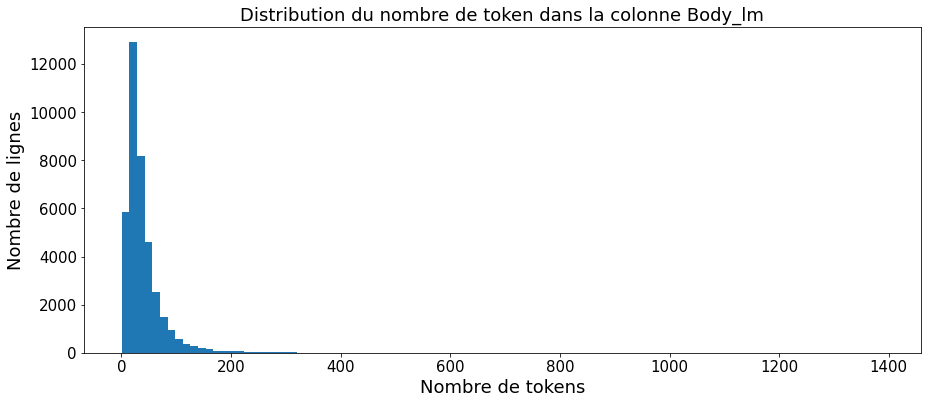

In [40]:
token_distribution('Body_lm')

In [42]:
# On utilise la colonne 'Body_pc' pour faire la selection sur les indices

pc_idx=[]
for i,data in df['Body_pc'].apply(lambda x: x.split(" ")).items():
    if (len(data) < 512) and (len(data) > 16):
        pc_idx.append(i)

In [43]:
df = df.loc[pc_idx]


 Le corps de texte le plus long contient 511 tokens. 



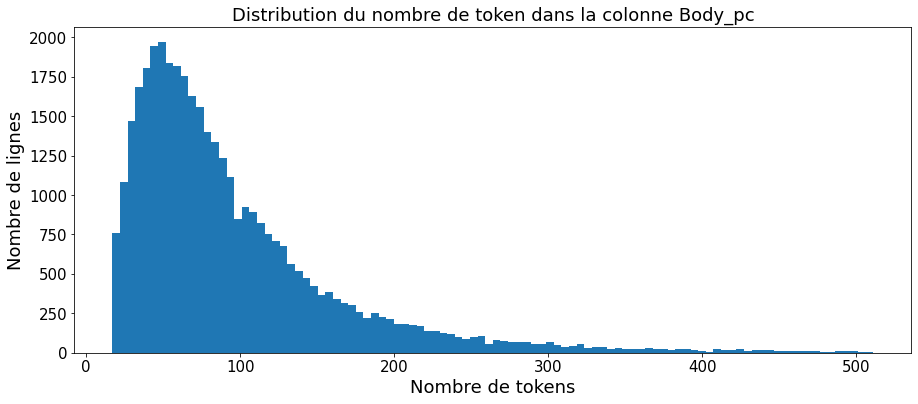

In [44]:
# Nouvelle distribution des tokens
token_distribution('Body_pc')


 Le corps de texte le plus long contient 430 tokens. 



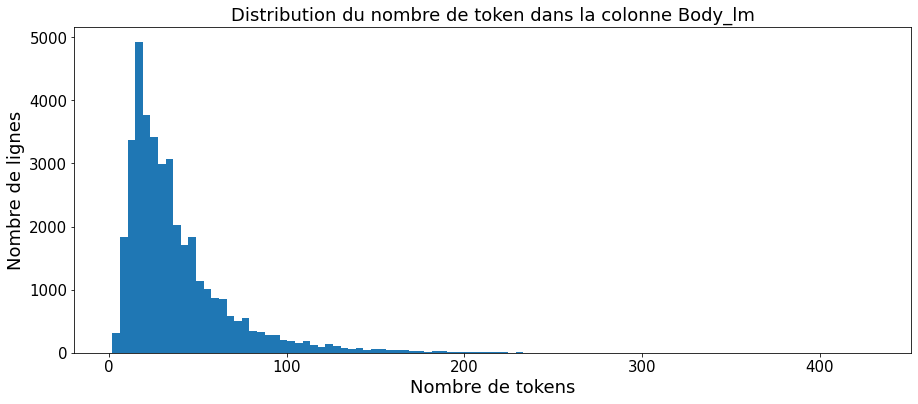

In [45]:
# Nouvelle distribution des tokens
token_distribution('Body_lm')

In [46]:
print("Le jeu de données compte {} tags uniques.".format(df.shape[0]))

(37960, 8)

In [42]:
reduction_df = df.shape[0]/df_orig.shape[0]
print("Le jeu de données a été réduit de {}%".format(round((1-reduction_df)*100, 2)))

Le jeu de données a été réduit de 22.88%


In [47]:
df['Best_Tags_count'].value_counts()
# .plot(kind='bar',figsize=(15,6))
# plt.show()

1    27114
2     9427
3     1419
Name: Best_Tags_count, dtype: int64

In [48]:
df = df.drop(['Best_Tags_count',
             ], axis=1)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37960 entries, 689677 to 665299
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Best_Tags  37960 non-null  object
 1   Body_pc    37960 non-null  object
 2   Body_lm    37960 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [50]:
df.to_csv('df_cleaned.csv')